In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

sys.path.insert(0, '..')
from data_wrangling import create_new_folder, get_image_info
from preprocessing import delete_corrupt_image

#### READ IN TRAIN DATASET

In [3]:
train = r'../train_images'
val = r'../val_images'
test = r'../test_images'

In [4]:
train_df = pd.read_csv(r'..\data\train.csv')
train_df.drop(labels='Unnamed: 0', axis=1,inplace=True)

#### CHECK DATASETS FOR ANY CORRUPT IMAGES

In [5]:
delete_corrupt_image(train)
delete_corrupt_image(val)
delete_corrupt_image(test)

Deleted 0 images
Deleted 0 images
Deleted 0 images


#### OBSERVE DISTRIBUTION OF DATASET

In [6]:
train_df.label.value_counts()

Impressionism             616
Cubism                    198
Expressionism              87
Pop Art                    82
Byzantine Art              44
Abstract Expressionism     11
Name: label, dtype: int64

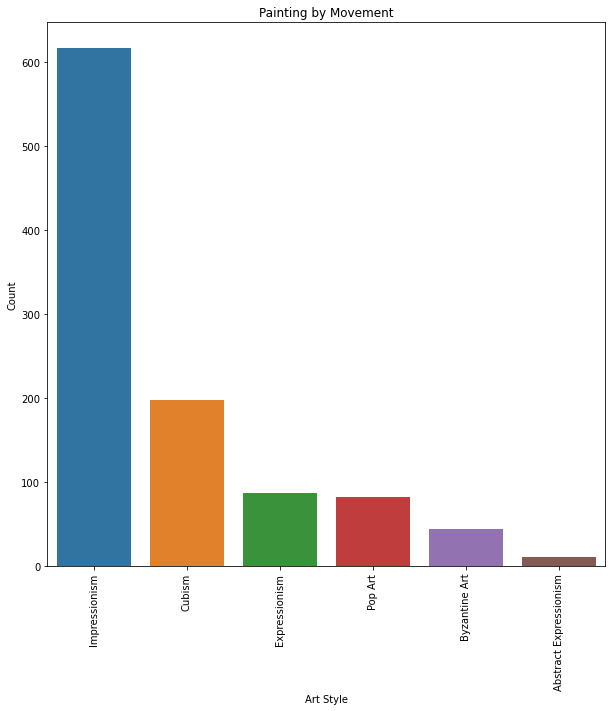

In [7]:
plt.figure(figsize=(10,10))
sns.barplot(x=train_df.label.value_counts().keys(), y=train_df.label.value_counts())
plt.xticks(rotation='vertical')
plt.xlabel('Art Style')
plt.ylabel('Count')
plt.title('Painting by Movement')

plt.show()

#### AUGMENT A SAMPLE OF THE DATA AND SAVE TO TRAINING FOLDER

In [8]:
#create generator for image augmentation
data_gen = ImageDataGenerator(rotation_range=40, 
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              brightness_range=(0.25, 1.0),
                              channel_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2, 
                              horizontal_flip=True,
                              samplewise_std_normalization = True,
                              fill_mode='nearest')

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\keras_preprocessing\image\image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
#augment data and add samples to smaller classes in training images only
#find max number of images for a genre 
maximum = max(train_df.label.value_counts())

for i in train_df.label.unique():
    num = int(train_df.label[train_df.label == i].value_counts())
    if num < maximum:
        sample = list(train_df.filepath.loc[train_df.label == i].sample(frac=.75, replace=False))
        for s in sample:
            img = load_img(s)
            x = img_to_array(img)
            x = x.reshape((1,) +x.shape)
            count=0
            
            for batch in data_gen.flow(x, batch_size=1, save_to_dir=os.path.join(train,i),
                                      save_prefix=f'{i}_aug', save_format='jpeg'):
                count+=1
                if count>0:
                    break

In [5]:
#get image information from train.csv
train_aug_df = get_image_info(train)
#save training samples to train.csv
train_aug_df.to_csv(r'..\data\train_augmented.csv')

#### OBSERVE NEW DISTRIBUTION OF TRAINING DATA

In [6]:
train_aug_df.label.value_counts()

Impressionism             616
Cubism                    490
Expressionism             216
Pop Art                   203
Byzantine Art             110
Abstract Expressionism     27
Name: label, dtype: int64

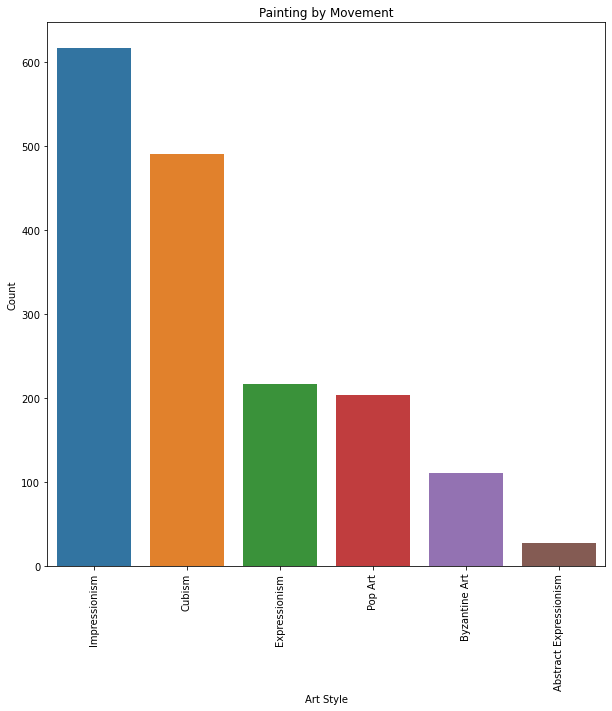

In [7]:
plt.figure(figsize=(10,10))
sns.barplot(x=train_aug_df.label.value_counts().keys(), y=train_aug_df.label.value_counts())
plt.xticks(rotation='vertical')
plt.xlabel('Art Style')
plt.ylabel('Count')
plt.title('Painting by Movement')

plt.show()

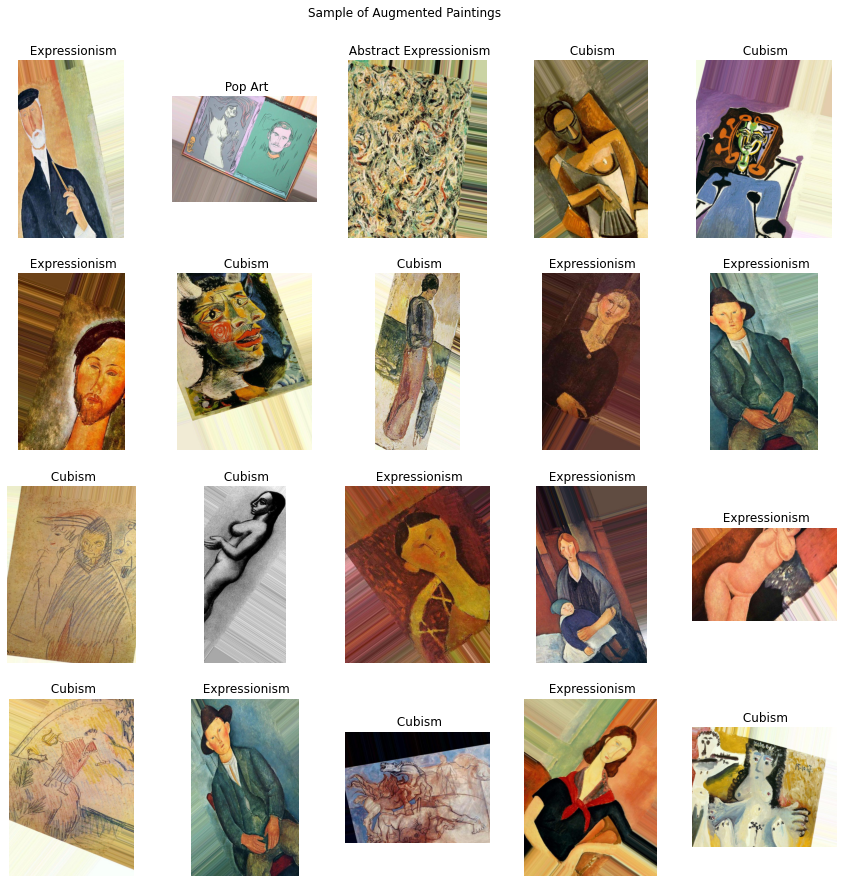

In [9]:
filepath = list(np.random.choice(train_aug_df.filepath[train_aug_df.filepath.str.contains('aug')], 20, replace=False))

plt.figure(figsize=(15,15))

for i in range(len(filepath)):
    ax = plt.subplot(4, 5, i + 1)
    image = plt.imread(filepath[i])
    title = train_aug_df.label.loc[train_aug_df.filepath == filepath[i]].to_string(index=False)
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
plt.suptitle(f'Sample of Augmented Paintings', y=0.93)
plt.savefig(f'../graphs/sample_augmented.jpg', bbox_inches='tight')
plt.show()